In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [2]:
device = torch.device("cuda") 
device

device(type='cuda')

In [3]:
indices = np.arange(0,50, 0.02)
synthetic_data = (np.sin(indices*3)+indices/10 + (indices/10)**2 + np.sin(indices*10)) #/ np.exp(indices/20)

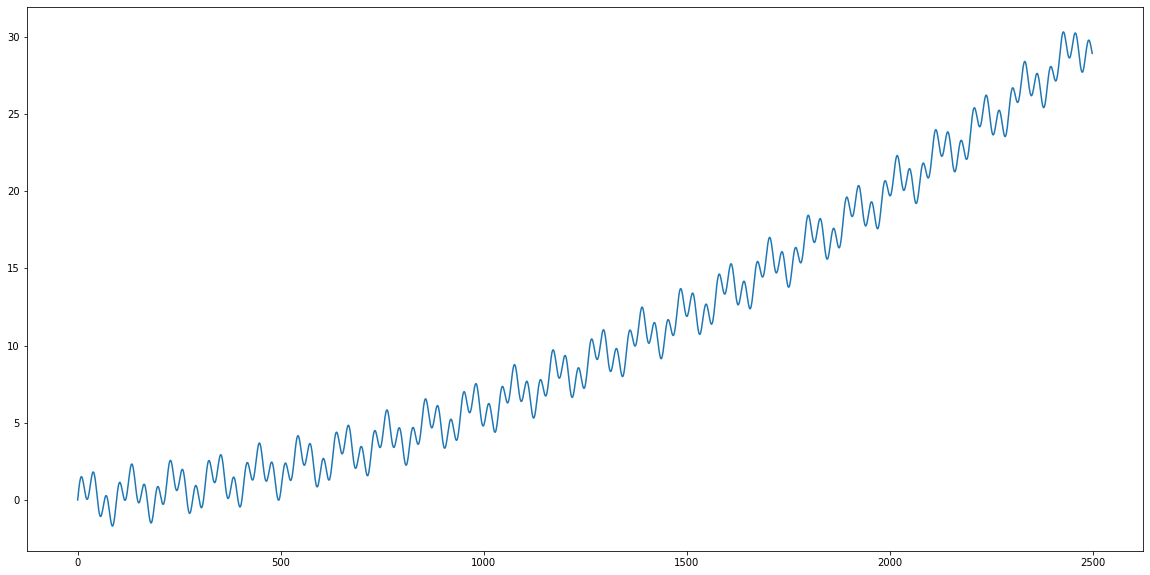

In [4]:
plt.figure(figsize=[20,10])
plt.plot(synthetic_data)
plt.show()

In [5]:
min_value = synthetic_data.min()
max_value = synthetic_data.max()

In [6]:
data_seq = []
data_targets = []
sequence_len = 150
for i in range(len(synthetic_data)-sequence_len-1):
    data_seq.append(torch.from_numpy(synthetic_data[i:i+sequence_len]))
    data_targets.append(synthetic_data[i+sequence_len+1])

In [7]:
data = (torch.stack(data_seq).float()-min_value)/max_value
data_targets = (torch.Tensor(data_targets).float()-min_value)/max_value
train_indices = np.random.rand(len(data_seq))>0.3
test_indices = ~train_indices
train_set = torch.utils.data.TensorDataset(data[train_indices], data_targets[train_indices])
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_data, test_targets = data[test_indices], data_targets[test_indices]

In [8]:
class SimpleRegressor(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x
    
model = SimpleRegressor(sequence_len,5,1).to(device)
model

SimpleRegressor(
  (linear1): Linear(in_features=150, out_features=5, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=5, out_features=1, bias=True)
)

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_fun = nn.MSELoss()

In [10]:
model.train() 

# Training loop
for epoch in range(41):
    for x, targets in train_loader:
        x = x.to(device)
        targets = targets.to(device)

        preds = model(x)
        preds = preds.squeeze(dim=1) 
        
        optimizer.zero_grad() 
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 0.0048
Epoch: 10, loss: 0.00158
Epoch: 20, loss: 0.000426
Epoch: 30, loss: 0.00022
Epoch: 40, loss: 0.000256


In [11]:
with torch.no_grad():
    test_preds = model(test_data.to(device))
    print(torch.abs(test_preds.squeeze()-test_targets.to(device)).mean())

tensor(0.0093, device='cuda:0')


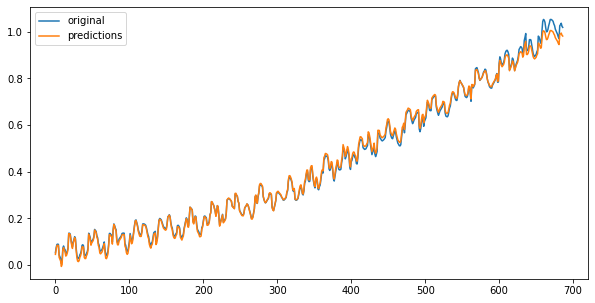

In [12]:
plt.figure(figsize=[10,5])
plt.plot(test_targets.numpy(), label = 'original')
plt.plot(test_preds.cpu().numpy(), label = 'predictions')
plt.legend()
plt.show()

## Konice laborki?

### Co poszło nie tak?

In [13]:
train_split = int(len(data)*0.7)
train_set = torch.utils.data.TensorDataset(data[:train_split], data_targets[:train_split])
train_loader = DataLoader(train_set, batch_size=32, drop_last=True)
test_data, test_targets = data[train_split:], data_targets[train_split:]

In [14]:
model = SimpleRegressor(sequence_len,5,1).to(device)
model
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_fun = nn.MSELoss()

# Training loop
for epoch in range(41):
    for x, targets in train_loader:
        x = x.to(device)
        targets = targets.to(device)

        preds = model(x)
        preds = preds.squeeze(dim=1) 
        
        optimizer.zero_grad() 
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 0.000621
Epoch: 10, loss: 0.000181
Epoch: 20, loss: 0.000159
Epoch: 30, loss: 0.00014
Epoch: 40, loss: 0.000146


In [15]:
with torch.no_grad():
    test_preds = model(test_data.to(device))
    print(torch.abs(test_preds.squeeze()-test_targets.to(device)).mean())

tensor(0.0959, device='cuda:0')


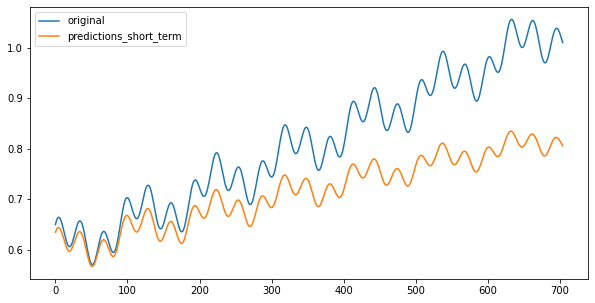

In [16]:
plt.figure(figsize=[10,5])
plt.plot(test_targets.numpy(), label = 'original')
plt.plot(test_preds.cpu().numpy(), label = 'predictions_short_term')
plt.legend()
plt.show()

# Sieć rekurencyjna

In [17]:
class RecurrentRegressor(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs, num_state):
        super().__init__()
        self.linear1 = nn.Linear(num_inputs + num_state, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear_out = nn.Linear(num_hidden, num_outputs)
        self.linear_state = nn.Linear(num_hidden, num_state)

    def forward(self, x, state):
        x = torch.cat([x, state],1)
        x = self.linear1(x)
        x = self.act_fn(x)
        out = self.linear_out(x)
        state = self.linear_state(x)
        return out, state
    
model = RecurrentRegressor(1,5,1,5).to(device)
model

RecurrentRegressor(
  (linear1): Linear(in_features=6, out_features=5, bias=True)
  (act_fn): Tanh()
  (linear_out): Linear(in_features=5, out_features=1, bias=True)
  (linear_state): Linear(in_features=5, out_features=5, bias=True)
)

### Dokończ pętlę uczącą poniżej:

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_fun = nn.MSELoss()

for epoch in range(41):
    for x, targets in train_loader:
        x = x.to(device)
        targets = targets.to(device)
        loss_total = 0
        state = torch.zeros(len(x),5).to(device)
        optimizer.zero_grad() 
        for i in range(x.size(1)):
            x_one = x[:,i].unsqueeze(1)
            if i < sequence_len - 1:
                target = targets[:,i+1]
            else:
                target = targets
                preds, state = model(x_one, state)
                preds = preds.squeeze(dim=1)
                loss = loss_fun(preds, target)
                loss_total += loss
        loss_total.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

IndexError: too many indices for tensor of dimension 1

In [ ]:
with torch.no_grad():
    state = torch.zeros(len(test_data),5).to(device)
    test_preds = []
    for i in range(test_data.size(1)):
        x_one = test_data[:,i].unsqueeze(1).to(device)
        preds, state = model(x_one, state)
    test_preds.append(preds)
    print(torch.abs((torch.cat(test_preds).squeeze() - test_targets.to(device))).mean())

In [ ]:
plt.figure(figsize=[10,5])
plt.plot(test_targets, label = 'original')
plt.plot(torch.cat(test_preds).squeeze().cpu().numpy(), label = 'predictions')
plt.legend()
plt.show()

# Sieci rekurencyjne w Torchu

In [22]:
batch_size = 2
input_size = 3
hidden_size = 4
num_layers = 2
rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=2, batch_first=False) #batch_first=False is default!!
rnn

RNN(3, 4, num_layers=2)

In [23]:
with torch.no_grad():
    sequence_len = 5
    x = torch.randn(sequence_len, batch_size, input_size)
    h0 = torch.randn(num_layers, batch_size, hidden_size)
    output, hn = rnn(x, h0)
output

tensor([[[ 0.0531, -0.2385,  0.7736, -0.3837],
         [ 0.7454,  0.3050,  0.2294, -0.2256]],

        [[ 0.0141, -0.5269,  0.2067, -0.3209],
         [ 0.7650, -0.3671,  0.5612, -0.4645]],

        [[ 0.4545, -0.0400,  0.2540, -0.2891],
         [ 0.6343, -0.6785,  0.2639, -0.6755]],

        [[ 0.5234, -0.3512,  0.4023, -0.4392],
         [ 0.2556, -0.3821,  0.0823, -0.5355]],

        [[ 0.4549, -0.4218,  0.2839, -0.4779],
         [ 0.5201,  0.0989,  0.1790, -0.2816]]])

In [24]:
output[-1]

tensor([[ 0.4549, -0.4218,  0.2839, -0.4779],
        [ 0.5201,  0.0989,  0.1790, -0.2816]])

In [25]:
hn

tensor([[[-0.2730,  0.7770,  0.6420,  0.1116],
         [-0.6520,  0.9260, -0.0608,  0.6839]],

        [[ 0.4549, -0.4218,  0.2839, -0.4779],
         [ 0.5201,  0.0989,  0.1790, -0.2816]]])

In [26]:
class RNNRegressor(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, out_size):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
        self.fc = nn.Linear(hidden_size, out_size)
        
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return hidden
    
    def forward(self, x, hidden):
        x = torch.transpose(x,0,1)
        all_outputs, hidden = self.rnn(x, hidden)
        out = all_outputs[-1] # We are interested only on the last output
        x = self.fc(out)
        return x, hidden
    
model = RNNRegressor(1,5,2,1).to(device)
model

RNNRegressor(
  (rnn): RNN(1, 5, num_layers=2)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_fun = nn.MSELoss()

for epoch in range(41):
    for x, targets in train_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden = model.init_hidden(x.size(0)).to(device)
        preds, last_hidden = model(x, hidden)
        preds = preds.squeeze(1)
        optimizer.zero_grad() 
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 0.0478
Epoch: 10, loss: 0.000899
Epoch: 20, loss: 0.000636
Epoch: 30, loss: 0.000509
Epoch: 40, loss: 0.0003


In [28]:
with torch.no_grad():
    hidden = model.init_hidden(len(test_data)).to(device)
    test_preds, _ = model(test_data.to(device).unsqueeze(2),hidden)
    print(torch.abs(test_preds.squeeze() - test_targets.to(device)).mean())

tensor(0.1243, device='cuda:0')


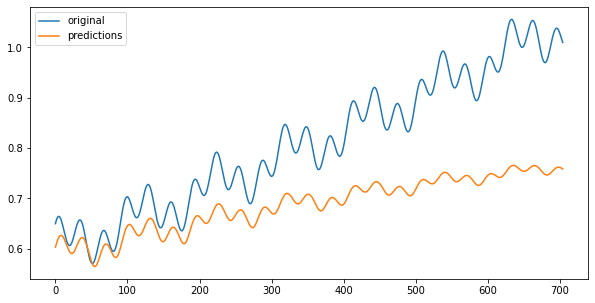

In [29]:
plt.figure(figsize=[10,5])
plt.plot(test_targets, label = 'original')
plt.plot(test_preds.squeeze().cpu().numpy(), label = 'predictions')
plt.legend()
plt.show()

## Czy możemy jakoś rozdzielić krótką i długą pamięć?

![LSTM](https://cdn-images-1.medium.com/max/1000/1*Ht2-sUJHi65wDwnR276k3A.png)

In [30]:
sequence_length = 5
num_layers = 1
batch_size = 3
hidden_size = 2
lstm = nn.LSTM(input_size = 1, hidden_size=hidden_size, num_layers=num_layers)
lstm_input = torch.randn(sequence_length, batch_size, 1)
hidden_0 = torch.randn(num_layers, batch_size, hidden_size)
cell_state_0 = torch.randn(num_layers, batch_size, hidden_size)
output, (hn, cn) = lstm(lstm_input, (hidden_0, cell_state_0))

In [31]:
print(output.size())
output

torch.Size([5, 3, 2])


tensor([[[ 0.3899, -0.4054],
         [-0.0816,  0.3062],
         [-0.1213,  0.3292]],

        [[ 0.3404, -0.5038],
         [-0.0595,  0.1892],
         [-0.0746,  0.2686]],

        [[ 0.1238, -0.3650],
         [ 0.2129, -0.0178],
         [-0.0588,  0.1738]],

        [[ 0.1479, -0.3310],
         [-0.0026,  0.0037],
         [-0.0404,  0.0817]],

        [[-0.0190, -0.1379],
         [-0.0238, -0.0174],
         [-0.0198,  0.0053]]], grad_fn=<StackBackward0>)

In [32]:
print(hn)
print(cn)

tensor([[[-0.0190, -0.1379],
         [-0.0238, -0.0174],
         [-0.0198,  0.0053]]], grad_fn=<StackBackward0>)
tensor([[[-0.0562, -0.2500],
         [-0.0636, -0.0346],
         [-0.0492,  0.0107]]], grad_fn=<StackBackward0>)


In [33]:
class LSTMRegressor(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, out_size):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
        self.fc = nn.Linear(hidden_size, out_size)
        
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        state = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return hidden, state
    
    def forward(self, x, hidden):
        x = torch.transpose(x,0,1)
        all_outputs, hidden = self.lstm(x, hidden)
        out = all_outputs[-1] # We are interested only on the last output
        x = self.fc(out)
        return x, hidden
    
model = LSTMRegressor(1,20,2,1).to(device)
model

LSTMRegressor(
  (lstm): LSTM(1, 20, num_layers=2)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_fun = nn.MSELoss()

for epoch in range(101):
    for x, targets in train_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device) 
        preds, last_hidden = model(x, (hidden,state))
        preds = preds.squeeze(1)
        optimizer.zero_grad() 
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 0.00104
Epoch: 10, loss: 0.000852
Epoch: 20, loss: 0.000595
Epoch: 30, loss: 0.000465
Epoch: 40, loss: 0.000275
Epoch: 50, loss: 6.32e-05
Epoch: 60, loss: 2.01e-05
Epoch: 70, loss: 1.65e-05
Epoch: 80, loss: 1.36e-05
Epoch: 90, loss: 5.45e-06
Epoch: 100, loss: 8.98e-06


In [35]:
with torch.no_grad():
    hidden, state = model.init_hidden(test_data.size(0))
    hidden, state = hidden.to(device), state.to(device) 
    test_preds, _ = model(test_data.to(device).unsqueeze(2),(hidden, state))
    print(torch.abs(test_preds.squeeze() - test_targets.to(device)).mean().item())

0.014663356356322765


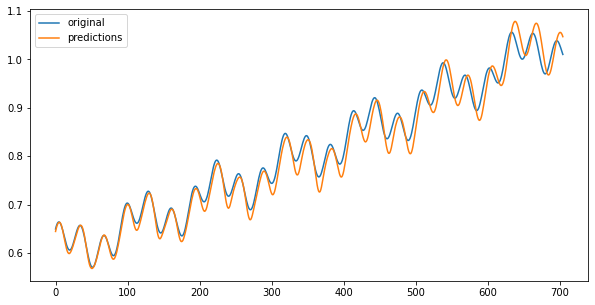

In [36]:
plt.figure(figsize=[10,5])
plt.plot(test_targets, label = 'original')
plt.plot(test_preds.squeeze().cpu().numpy(), label = 'predictions')
plt.legend()
plt.show()

### Mini zadanie: Jak wyglądałyby predykcje w oparciu o poprzednie predykcje?

In [46]:
test_targets[0:150]

tensor([0.6497, 0.6552, 0.6595, 0.6624, 0.6640, 0.6641, 0.6628, 0.6603, 0.6566,
        0.6520, 0.6467, 0.6409, 0.6348, 0.6288, 0.6231, 0.6179, 0.6134, 0.6099,
        0.6075, 0.6062, 0.6061, 0.6073, 0.6095, 0.6128, 0.6170, 0.6218, 0.6271,
        0.6326, 0.6381, 0.6433, 0.6480, 0.6518, 0.6548, 0.6566, 0.6571, 0.6563,
        0.6542, 0.6508, 0.6462, 0.6405, 0.6340, 0.6267, 0.6189, 0.6110, 0.6032,
        0.5957, 0.5889, 0.5828, 0.5778, 0.5740, 0.5715, 0.5704, 0.5707, 0.5724,
        0.5753, 0.5793, 0.5844, 0.5901, 0.5964, 0.6029, 0.6094, 0.6157, 0.6214,
        0.6264, 0.6306, 0.6336, 0.6356, 0.6363, 0.6359, 0.6343, 0.6317, 0.6282,
        0.6240, 0.6194, 0.6145, 0.6097, 0.6052, 0.6012, 0.5979, 0.5957, 0.5946,
        0.5947, 0.5962, 0.5991, 0.6033, 0.6088, 0.6154, 0.6229, 0.6313, 0.6401,
        0.6492, 0.6583, 0.6671, 0.6754, 0.6829, 0.6894, 0.6947, 0.6988, 0.7016,
        0.7030, 0.7030, 0.7018, 0.6995, 0.6962, 0.6921, 0.6875, 0.6827, 0.6779,
        0.6733, 0.6692, 0.6658, 0.6632, 

In [47]:
with torch.no_grad():
    hidden, state = model.init_hidden(1)
    hidden, state = hidden.to(device), state.to(device)
    hidden = (hidden, state)
    x_one = test_targets[0:150].unsqueeze(1).to(device)
    preds = []
    for i in range(len(test_targets)):
        pred, hidden = model(x_one.unsqueeze(0), hidden)
        x_one = torch.cat([x_one[1:], pred])
        preds.append(pred.item())

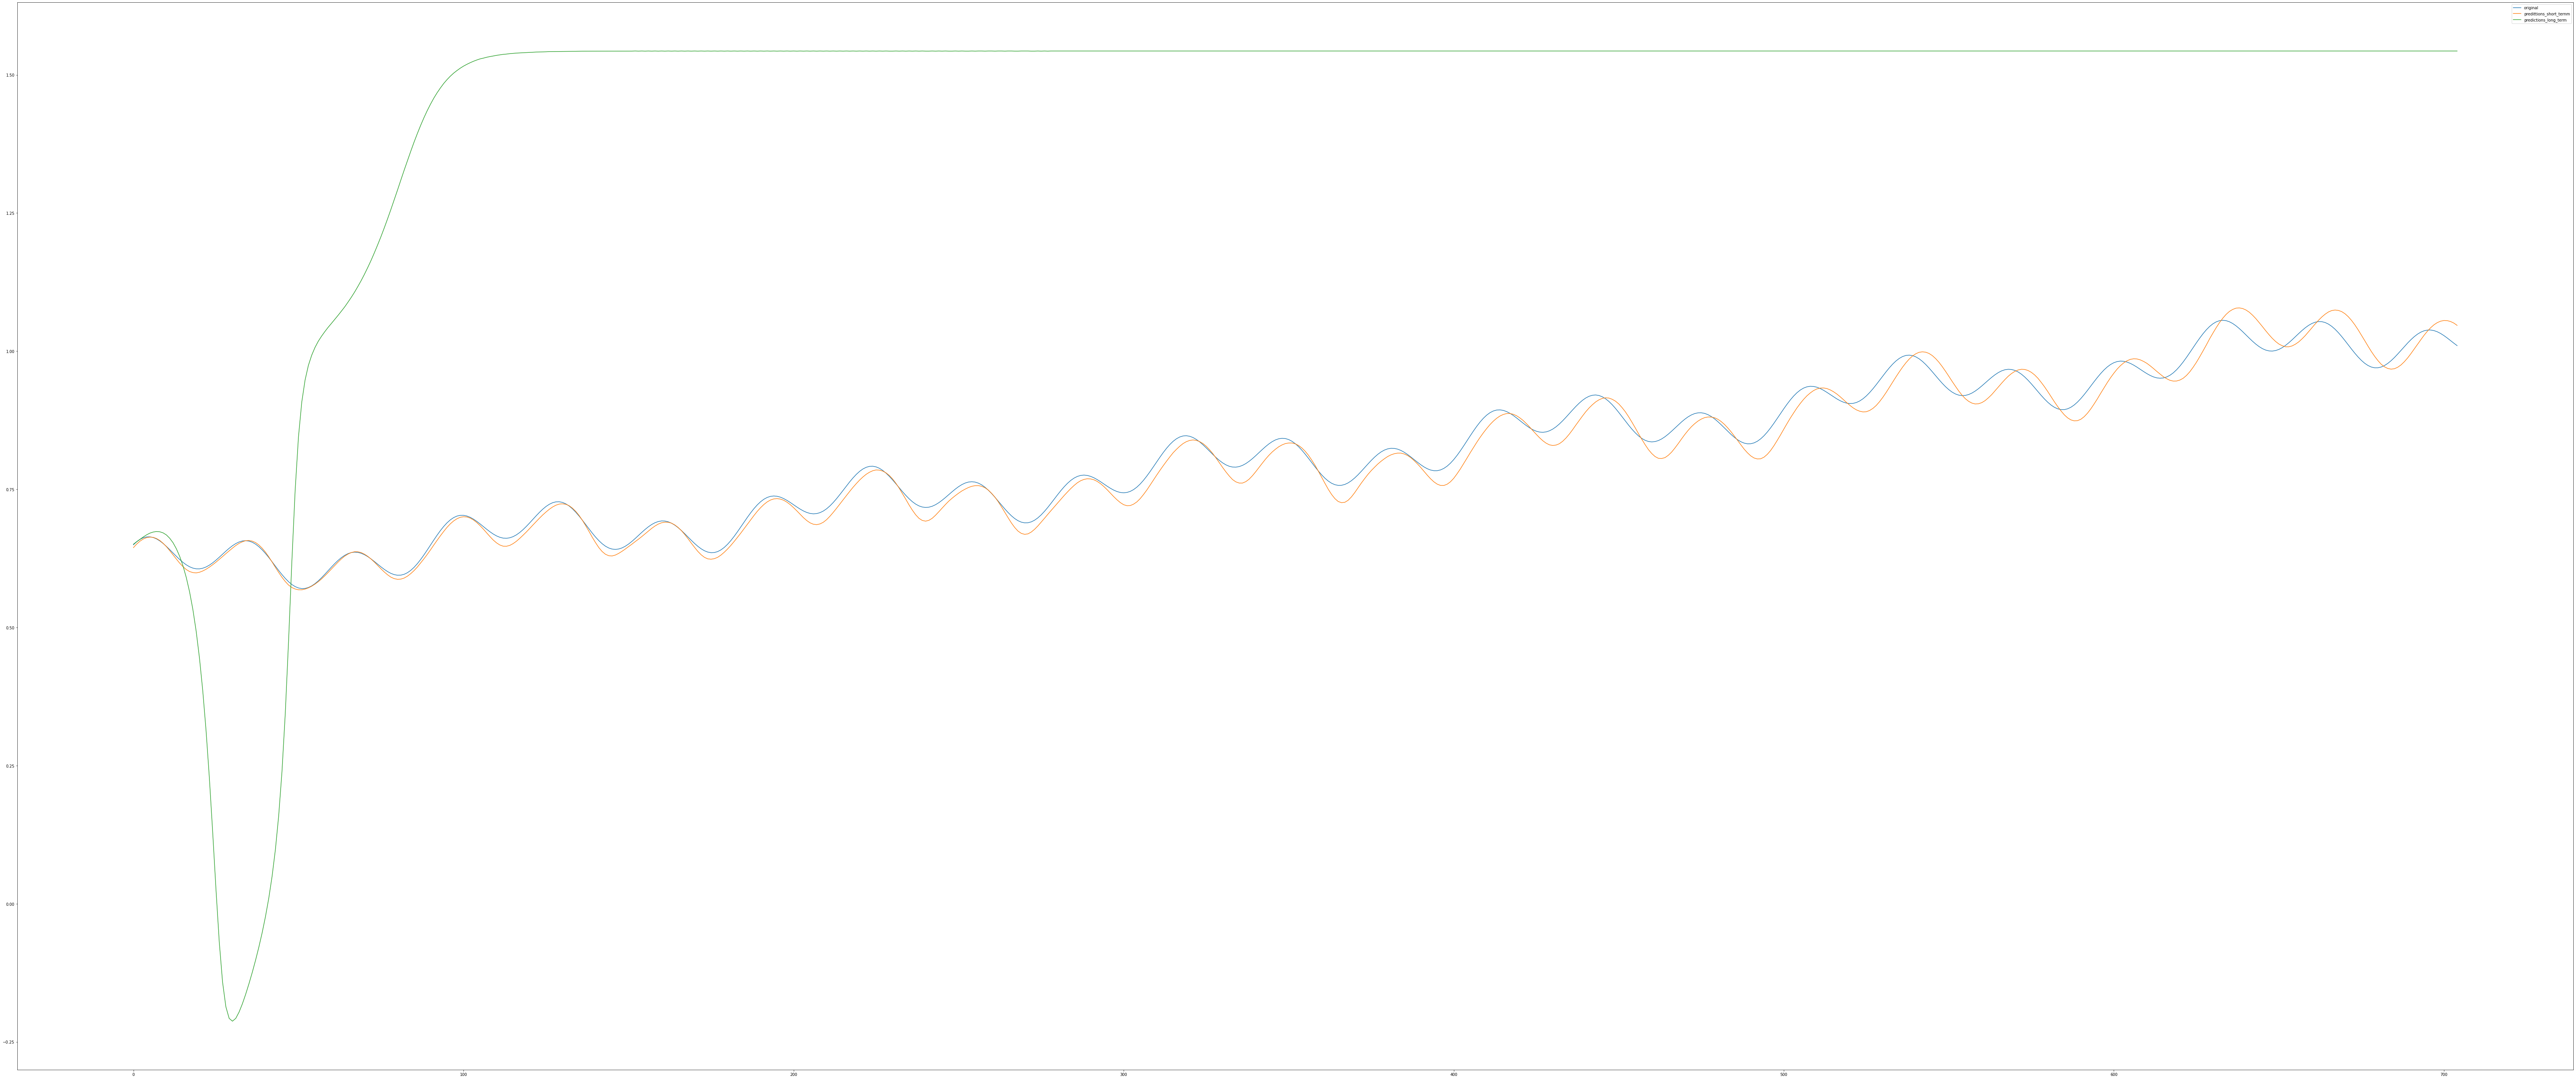

In [48]:
plt.figure(figsize=[119,51])
plt.plot(test_targets, label = 'original')
plt.plot(test_preds.squeeze().cpu().numpy(), label = 'predittions_short_ternm')
plt.plot(preds, label = 'predictions_long_term')
plt.legend()
plt.show()

# Predykcja Sequence to sequence

In [49]:
stock_price = pd.read_csv("https://galera.ii.pw.edu.pl/~kdeja/data/all_stocks_5yr.csv")

In [50]:
mastercard_stock = stock_price[stock_price.Name=="MA"].open.values
visa_stock = stock_price[stock_price.Name=="V"].open.values

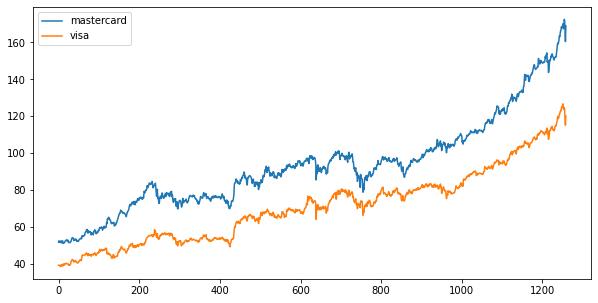

In [51]:
plt.figure(figsize=[10,5])
plt.plot(mastercard_stock, label = 'mastercard')
plt.plot(visa_stock, label = 'visa')
plt.legend()
plt.show()

In [52]:
m_min_value = mastercard_stock.min()
m_max_value = mastercard_stock.max()
v_min_value = visa_stock.min()
v_max_value = visa_stock.max()

In [53]:
data_seq = []
data_targets = []
sequence_len = 50
for i in range(len(mastercard_stock)-sequence_len):
    data_seq.append(torch.from_numpy(mastercard_stock[i:i+sequence_len]))
    data_targets.append(torch.from_numpy(visa_stock[i:i+sequence_len]))
    
data = (torch.stack(data_seq).float()-m_min_value)/m_max_value
data_targets = (torch.stack(data_targets).float()-v_min_value)/v_max_value    

train_split = int(len(data)*0.7)
train_set = torch.utils.data.TensorDataset(data[:train_split], data_targets[:train_split])
train_loader = DataLoader(train_set, batch_size=32, drop_last=True)
train_set = torch.utils.data.TensorDataset(data[:train_split], data_targets[:train_split])
train_loader = DataLoader(train_set, batch_size=32, drop_last=True)
test_data, test_targets = data[train_split:], data_targets[train_split:]

In [54]:
sequence_length = 5
num_layers = 1
batch_size = 3
hidden_size = 2
projection_size = 1

lstm = nn.LSTM(input_size = 1, hidden_size=hidden_size, num_layers=num_layers, proj_size=projection_size)
lstm_input = torch.randn(sequence_length, batch_size, 1)
hidden_0 = torch.randn(num_layers, batch_size, projection_size)
cell_state_0 = torch.randn(num_layers, batch_size, hidden_size)
output, (hn, cn) = lstm(lstm_input, (hidden_0, cell_state_0))

In [55]:
output

tensor([[[ 0.0228],
         [-0.0100],
         [-0.0077]],

        [[ 0.0272],
         [ 0.0021],
         [-0.0013]],

        [[ 0.0197],
         [ 0.0050],
         [ 0.0046]],

        [[ 0.0064],
         [ 0.0127],
         [ 0.0140]],

        [[ 0.0126],
         [ 0.0211],
         [ 0.0145]]], grad_fn=<StackBackward0>)

In [56]:
class LSTM_Seq_Regressor(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, out_size):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.proj_size = out_size
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, proj_size=out_size)
        
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.proj_size)
        state = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return hidden, state
    
    def forward(self, x, hidden):
        x = torch.transpose(x,0,1)
        all_outputs, hidden = self.lstm(x, hidden)
        all_outputs = torch.transpose(all_outputs,0,1)
        return all_outputs, hidden
    
model = LSTM_Seq_Regressor(1,50,2,1).to(device)
model

LSTM_Seq_Regressor(
  (lstm): LSTM(1, 50, proj_size=1, num_layers=2)
)

In [57]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_fun = nn.MSELoss()

# Training loop
for epoch in range(101):
    for x, targets in train_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device) 
        preds, last_hidden = model(x, (hidden,state))
        preds = preds.squeeze(2)
        optimizer.zero_grad() 
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 0.0204
Epoch: 10, loss: 0.0182
Epoch: 20, loss: 0.0179
Epoch: 30, loss: 0.00404
Epoch: 40, loss: 0.00339
Epoch: 50, loss: 0.0032
Epoch: 60, loss: 0.00309
Epoch: 70, loss: 0.00301
Epoch: 80, loss: 0.00295
Epoch: 90, loss: 0.00288
Epoch: 100, loss: 0.00282


In [58]:
with torch.no_grad():
    selected_test_targets = []
    preds = []
    for i in range(0,len(test_targets),sequence_len):
        hidden, state = model.init_hidden(1)
        hidden, state = hidden.to(device), state.to(device) 
        selected_test_targets.append(test_targets[i])
        pred, _ = model(test_data[i].to(device).unsqueeze(0).unsqueeze(2), (hidden,state))
        preds.append(pred.squeeze())

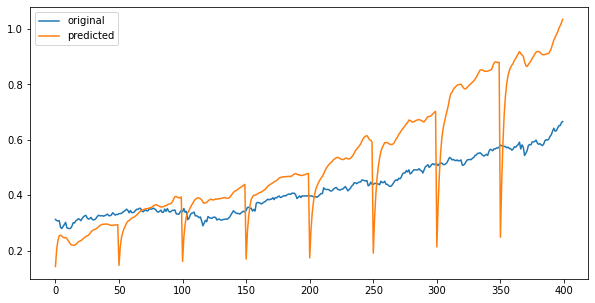

In [59]:
plt.figure(figsize=[10,5])
plt.plot(torch.cat(selected_test_targets).cpu().numpy(), label = 'original')
plt.plot(torch.cat(preds).cpu().numpy(), label = 'predicted')
plt.legend()
plt.show()

### Co się stało, skąd takie dziwne predykcje?

# Klasyfikacja serii

In [ ]:
libras = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/libras/movement_libras.data",header=None)

In [ ]:
libras.head()

In [ ]:
classes = libras[90].values
data = libras.values[:,:-1]

In [ ]:
data = torch.from_numpy(data).float()
data_targets = torch.from_numpy(classes).long()

train_indices = np.random.rand(len(data))>0.3
test_indices = ~train_indices
train_set = torch.utils.data.TensorDataset(data[train_indices], data_targets[train_indices])
train_loader = DataLoader(train_set, batch_size=32)
test_data, test_targets = data[test_indices], data_targets[test_indices]

### Napisz klasyfikator

In [ ]:
class LsTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, out_size, bidirectional = False):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        if bidirectional:
            self.bidirectional = 2
        else
            self.bidirectional = 1
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size*90*self.bidirectional, out_size)

    def __init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers*self.bidirectional, batch_size, self.hidden_size)
        state = torch.zeros(self.num_layers*self.bidirectional, batch_size, self.hidden_size)
        return hidden, state

    def forward(self, x, hidden):
        x = torch.transpose(x,0,1)
        all_outputs, hidden = self.lstm(x, hidden)
        all_outputs = torch.transpose()
